In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import itertools
import time
import sys

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import nltk
nltk.download('rslp')

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from itertools import combinations
import cloudpickle as cp
import scikitplot as skplt

import warnings
warnings.simplefilter("ignore")

[nltk_data] Downloading package rslp to /home/jovyan/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


# Index:
* [Data Extraction](#data-extraction)
* [Data Formatting](#data-formatting)
    * [NLP](#nlp)
    * [Pre-Processor](#pre-processor)
    * [Data Split](#data-split)
* [Modeling](#modeling)
* [Model Validation](#model-validation)
    * [Random Search](#random-search)
        * [Text Hyperparameters](#text-hyperparameters)
        * [Validation Metrics](#validation-metrics)
    * [Test Metrics](#test-metrics)
* [Model Exportation](#model-exportation)

In [2]:
# Set a seed value
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

## Data Extraction <a class="anchor" id="data-extraction"></a>

In [3]:
DATASET_PATH = os.getenv("DATASET_PATH")

sample = pd.read_csv(DATASET_PATH)
sample.shape

(38000, 15)

In [4]:
sample.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


In [5]:
sample.isna().sum(axis=0)

product_id               0
seller_id                0
query                    0
search_page              0
position                 0
title                    0
concatenated_tags        2
creation_date            0
price                    0
weight                  58
express_delivery         0
minimum_quantity         0
view_counts              0
order_counts         20105
category                 0
dtype: int64

In [6]:
sample['category'].value_counts()

Lembrancinhas         17524
Decoração              8723
Bebê                   6930
Papel e Cia            2750
Outros                 1133
Bijuterias e Jóias      940
Name: category, dtype: int64

## Data Formatting <a class="anchor" id="data-formatting"></a>

We selected all columns from the CSV file, with the exception of the product_id and seller_id columns, as they don't contain meaningful information about the categories we want to predict. 

In [7]:
numerical_columns = sample.select_dtypes("number").columns.tolist()[2:]
text_columns = ['title', 'query', 'concatenated_tags']

In [8]:
X = sample[numerical_columns + text_columns]
y = sample["category"]

X.loc[:, 'title'] = X['title'].str.lower()
X.loc[:, text_columns] = X.loc[:, text_columns].fillna("")

### NLP <a class="anchor" id="nlp"></a>

We used Bag of Words in our pipeline, because it is a simple way to extract information from the text. We also experimented with Tf-idf, which improved our results.

In [9]:
class TextColumnConcatenation(BaseEstimator):

    def __init__(self, columns = ['title']):
        self.columns = columns
        
    def transform(self, X):
        if len(self.columns) > 1:
            return X[self.columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
        else:
            return X[self.columns[0]]

    def fit(self, X, y=None):
        return self

In [10]:
class CountVectorizerWithStemming(CountVectorizer):
    
    def __init__(self, stemming=False, token_pattern=r"(?u)\b\w\w+\b", stop_words=None):
        self.stemming = stemming
        self.token_pattern = token_pattern
        self.stop_words = stop_words
        
        parameters = {"token_pattern": token_pattern,
                      "stop_words": stop_words}
        if stemming:
            
            analyzer = CountVectorizer(**parameters).build_analyzer()
            stemmer = nltk.stem.RSLPStemmer()
            
            def apply_stem(sentence):
                return (stemmer.stem(w) for w in analyzer(sentence))
        
            parameters['analyzer'] = apply_stem
        
        super().__init__(**parameters)

In [11]:
def save_model(model, path):
    with open(path, "wb") as file:
        cp.dump(model, file)
    print("Model saved at:", path)

    
def load_model(path):
    with open(path, "rb") as file:
        return cp.load(file)

### Pre-processor <a class="anchor" id="pre-processor"></a>

In [12]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

text_transformer = Pipeline(steps=[
    ("text_column_concatenation", TextColumnConcatenation()),
    ("count_vectorizer", CountVectorizerWithStemming()),
    ("tf_idf", "passthrough"),
    ("scaler", StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', numerical_transformer, numerical_columns),
    ('categorical', text_transformer, text_columns)
])

### Data Split <a class="anchor" id="data-split"></a>

The data were divided into training and test subsets. We use stratification so that the proportion of classes is maintained in both subsets of the data.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed_value, test_size=.2, stratify=y)

## Modeling <a class="anchor" id="modeling"></a>

We used a combination of simple classifiers (Logistic Regression, Decision Tree) and more complex ones (Random Forest, Multi-Layer Perceptron). And we chose the best one based on the validation metrics.

In [14]:
pipe_log = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("classifier", LogisticRegression(random_state=seed_value))
    ]
)

pipe_tree = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=seed_value))
    ]
)

pipe_rf = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("classifier", RandomForestClassifier(random_state=seed_value))
    ]
)

pipe_mlp = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("classifier", MLPClassifier(max_iter=100, random_state=seed_value))
    ]
)

## Model Validation <a class="anchor" id="model-validation"></a>

For validation and hyperparameter search, we used RandomSearch and StratifiedKfold. RandomSearch is usually better than GridSearch and less computationally expensive. 

Since we have an imbalanced dataset, we shouldn't use accuracy as our only metric. In this stage, we used f1, precision, recall and the ROC AUC score. Our random search optimization uses the ROC AUC score to return the best model.

We also manually tweaked the hyperparameters for some promissing models.

### Random Search <a class="anchor" id="random-search"></a>

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value)

In [16]:
scoring = {'f1': 'f1_weighted', 'precision': 'precision_weighted', 'recall': 'recall_weighted', 'roc_auc': 'roc_auc_ovo_weighted'}

In [17]:
def search_pipeline(pipeline, search_space, scoring, cv, random_state, X, y, load_best=False, n_iter=10,
                    model_name=None):
    """ Creates a random search for pipeline, fits the data, and returns the random search object
        
        if load_best is true, then it skips training and loads the best model instead
    """
    if model_name == None:
        model_name = f"RandomSearch{pipeline['classifier'].__class__.__name__}.pkl"
    
    best_models_path = os.getenv("BEST_MODELS_PATH")
    model_path = os.path.join(best_models_path, model_name)
    
    if load_best:
        search = load_model(model_path)
    else:
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=search_space,
            cv=cv,
            verbose=1,
            n_jobs=-1,
            random_state=random_state,
            scoring=scoring,
            refit="roc_auc",
            n_iter=n_iter,
            return_train_score=True,
        )
        start = time.time()
        search.fit(X_train, y_train)
        stop = time.time()
        print(f"Training time: {(stop - start) / 60} minutes")
        save_model(search, model_path)       
    
    return search

In [18]:
def get_search_metrics(search):
    best_index = search.best_index_
    metrics = search.scorer_.keys()
    data_modes = ["train", "test"]
    statistics = ["mean", "std"]
    
    iterables = [data_modes, statistics]
    index = pd.MultiIndex.from_product(iterables, names=["data", "statistic"])
    
    df = pd.DataFrame(index=index, columns=metrics)
    
    for metric in metrics:
        for data_mode in data_modes:
            for statistic in statistics:
                df.loc[(data_mode, statistic), 
                       metric] =  search.cv_results_[f'{statistic}_{data_mode}_{metric}'][best_index]
    return round(df, 3)
        
        

#### Text-Hyperparameters <a class="anchor" id="text-hyperparameters"></a>

We used hyperparameters in our data processing phase to help with generalization. These hyperparameters are 

* stemming
* token patterns 
* stop words. 

Token patterns are being used to select words with the length in a certain interval. Smaller and bigger words don't help our classifier as they don't contain meaningful information.

In [19]:
columns_combinations = []
for r in range(1, len(text_columns) + 1):
    combination = []
    for value in combinations(text_columns, r):
        combination.append(list(value))
    columns_combinations += combination
columns_combinations

[['title'],
 ['query'],
 ['concatenated_tags'],
 ['title', 'query'],
 ['title', 'concatenated_tags'],
 ['query', 'concatenated_tags'],
 ['title', 'query', 'concatenated_tags']]

In [20]:
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-pt/master/stopwords-pt.txt"
stopwords = pd.read_csv(stopwords_url, header=None)[0].tolist()
stopwords[:10]

['a',
 'acerca',
 'adeus',
 'agora',
 'ainda',
 'alem',
 'algmas',
 'algo',
 'algumas',
 'alguns']

In [21]:
def get_regex_word(min_word, max_word):
    return rf'(?u)\b[^\d\W]{{{min_word},{max_word}}}\b'


min_word_length_list = [3, 4, 5, 6]
max_word_length_list = [16, 15, 14]

patterns = []
for min_word_length in min_word_length_list:
    for max_word_length in max_word_length_list:
        patterns.append(get_regex_word(min_word_length, max_word_length))
patterns

['(?u)\\b[^\\d\\W]{3,16}\\b',
 '(?u)\\b[^\\d\\W]{3,15}\\b',
 '(?u)\\b[^\\d\\W]{3,14}\\b',
 '(?u)\\b[^\\d\\W]{4,16}\\b',
 '(?u)\\b[^\\d\\W]{4,15}\\b',
 '(?u)\\b[^\\d\\W]{4,14}\\b',
 '(?u)\\b[^\\d\\W]{5,16}\\b',
 '(?u)\\b[^\\d\\W]{5,15}\\b',
 '(?u)\\b[^\\d\\W]{5,14}\\b',
 '(?u)\\b[^\\d\\W]{6,16}\\b',
 '(?u)\\b[^\\d\\W]{6,15}\\b',
 '(?u)\\b[^\\d\\W]{6,14}\\b']

In [22]:
text_hyperparams = {
    "preprocessor__categorical__text_column_concatenation__columns": columns_combinations,
    "preprocessor__categorical__count_vectorizer__stop_words": [None, stopwords],
    "preprocessor__categorical__count_vectorizer__token_pattern": patterns,
    "preprocessor__categorical__count_vectorizer__stemming": [False, True],
    "preprocessor__categorical__tf_idf": ["passthrough", TfidfTransformer()],
}

#### Validation Metrics <a class="anchor" id="validation-metrics"></a>

In [23]:
load_best = True #change this flag to True if you want to run the random search
n_iter = 70

In [24]:
metrics = {'accuracy': 'accuracy', 'f1': 'f1_weighted', 'precision': 'precision_weighted', 'recall': 'recall_weighted', 'roc_auc': 'roc_auc_ovo_weighted'}

In [25]:
search_space_tree = {
    "classifier__criterion": ['gini', 'entropy'],
    "classifier__max_depth": [2, 4, 6, 8, 10, 12]
}

search_space_tree.update(text_hyperparams)


best_pipe_tree = search_pipeline(pipe_tree, search_space_tree, scoring, cv, seed_value, 
                                                  X_train, y_train, load_best=load_best, n_iter=n_iter)
get_search_metrics(best_pipe_tree)

accuracy        f1 precision    recall   roc_auc
data  statistic                                                  
train mean       0.804613  0.791825  0.826481  0.804613  0.905318
      std        0.001397  0.003026  0.004252  0.001397  0.000937
test  mean       0.776151  0.760376  0.789581  0.776151  0.875802
      std        0.004631  0.006112  0.002520  0.004631  0.003029

In [26]:
search_space_log = {
    "classifier__penalty": ['l2', 'l1'],
    "classifier__C": np.logspace(0, 4, 10),
    "classifier__solver":['newton-cg', 'saga', 'liblinear']
}

search_space_log.update(text_hyperparams)

best_pipe_log = search_pipeline(pipe_log, search_space_log, scoring,  cv, seed_value,
                                X_train, y_train, load_best=load_best, n_iter=n_iter);
get_search_metrics(best_pipe_log)

accuracy        f1 precision    recall   roc_auc
data  statistic                                                  
train mean       0.930625  0.929925  0.930725  0.930625  0.991194
      std        0.004733  0.004882  0.004680  0.004733  0.001410
test  mean       0.876941  0.875005  0.875405  0.876941  0.969767
      std        0.002937  0.002700  0.002866  0.002937  0.001732

In [27]:
search_space_rf = {
    "classifier__n_estimators": [10, 100, 1000],
    "classifier__max_depth":[5, 8, 15, 25, 30, None],
    "classifier__min_samples_leaf":[1, 2, 5, 10, 15, 100],
    "classifier__max_leaf_nodes": [2, 5, 10]
}

best_pipe_rf = search_pipeline(pipe_rf, search_space_rf, scoring, cv, seed_value, 
                               X_train, y_train, load_best=load_best, n_iter=n_iter)
get_search_metrics(best_pipe_rf)

accuracy        f1 precision    recall   roc_auc
data  statistic                                                  
train mean       0.517459  0.397447  0.632506  0.517459  0.919295
      std        0.003938  0.007267  0.010670  0.003938  0.000510
test  mean       0.516184  0.395281  0.627072  0.516184  0.916430
      std        0.004699  0.008726  0.001614  0.004699  0.002095

In [28]:
pipe_rf_text = Pipeline(
    [
        ('preprocessor', text_transformer),
        ("classifier", RandomForestClassifier(random_state=seed_value, n_jobs=-1))
    ]
)

params_rf_text = {
    "classifier__n_estimators": [100],
    "preprocessor__text_column_concatenation__columns": [['title', 'concatenated_tags']],
    "preprocessor__count_vectorizer__stop_words": [stopwords],
    "preprocessor__count_vectorizer__token_pattern": ['(?u)\\b[^\\d\\W]{3,15}\\b'],
    "preprocessor__count_vectorizer__stemming": [False],
    "preprocessor__tf_idf": [TfidfTransformer()],
}

manual_pipe_rf = search_pipeline(pipe_rf_text, params_rf_text, scoring, cv, seed_value, 
                                 X_train, y_train, load_best=False, n_iter=1, 
                                 model_name="ManualRandomForest.pkl")

get_search_metrics(manual_pipe_rf)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training time: 1.460862410068512 minutes
Model saved at: /usr/src/data/best_models/ManualRandomForest.pkl


f1 precision    recall   roc_auc
data  statistic                                        
train mean       0.998364  0.998365  0.998363  0.999954
      std        0.000120  0.000121  0.000120  0.000006
test  mean       0.903160  0.906249  0.905461  0.979593
      std        0.003509  0.003123  0.003449  0.000958

In [29]:
search_space_mlp = {
    'classifier__hidden_layer_sizes': [(10, 30, 10),(20,)],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': [0.0001, 0.05],
    'classifier__learning_rate': ['constant', 'adaptive']
}

search_space_mlp.update(text_hyperparams)

best_pipe_mlp = search_pipeline(pipe_mlp, search_space_mlp, scoring, cv, seed_value, 
                                X_train, y_train, load_best=load_best, n_iter=n_iter)

get_search_metrics(best_pipe_mlp)

accuracy        f1 precision    recall   roc_auc
data  statistic                                                  
train mean       0.990855  0.990848  0.990866  0.990855  0.999888
      std        0.000777  0.000778  0.000776  0.000777  0.000017
test  mean       0.871283  0.870587  0.870271  0.871283  0.961227
      std        0.005297  0.005220  0.005237  0.005297  0.001061

In [30]:
search_list = [best_pipe_tree, best_pipe_log, best_pipe_rf, best_pipe_mlp, manual_pipe_rf]

best_search_index = max(range(len(search_list)), key=lambda i: search_list[i].best_score_)
best_search = search_list[best_search_index]

best_score = best_search.best_score_
best_model = best_search.best_estimator_


print(f"Best Model: {best_model['classifier'].__class__.__name__} | Best ROC-AUC: {best_score}")

Best Model: RandomForestClassifier | Best ROC-AUC: 0.9795926695902015


In [31]:
validation_metrics = get_search_metrics(best_search)
with open(os.getenv("METRICS_PATH"), 'w') as f:
    f.write(f"Validation Metrics: \n{validation_metrics.to_string()}")

### Test Metrics  <a class="anchor" id="test-metrics"></a>

In [32]:
best_model.fit(X_train, y_train);

In [33]:
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)

In [34]:
labels = pd.unique(y_train)
metrics = ["f1", "precision", "recall"]#, "roc_auc"]
data_mode_list = ["train", "test"]
iterables = [metrics, data_mode_list]
index = pd.MultiIndex.from_product(iterables, names=["metric", "data"])
test_metrics_df = pd.DataFrame(index=index, columns=labels)

y_tuples = [(y_train, y_train_pred, y_train_proba), (y_test, y_test_pred, y_test_proba)]

for data_mode, y_tuple in zip(data_mode_list, y_tuples):
    y_true, y_pred, y_proba = y_tuple
    test_metrics_df.loc[("f1", data_mode), :] = f1_score(y_true, y_pred, average=None, labels=labels)
    test_metrics_df.loc[("precision", data_mode), :] = precision_score(y_true, y_pred, average=None, labels=labels)
    test_metrics_df.loc[("recall", data_mode), :] = recall_score(y_true, y_pred, average=None, labels=labels)
    #test_metrics_df.loc[("roc_auc", data_mode), :] = roc_auc_score(y_true, y_proba, average=None, 
    #                                                               labels=labels[0])

test_metrics_df

Bebê Decoração Lembrancinhas Papel e Cia    Outros  \
metric    data                                                            
f1        train  0.998466  0.998854      0.998324    0.994558  0.996685   
          test   0.910237  0.920835      0.934950    0.802372  0.724324   
precision train  0.998917  0.998854      0.998359    0.992308  0.998893   
          test   0.936641  0.918472      0.904292    0.878788  0.930556   
recall    train  0.998016  0.998854      0.998288    0.996818  0.994487   
          test   0.885281  0.923209      0.967760    0.738182  0.592920   

                Bijuterias e Jóias  
metric    data                      
f1        train           1.000000  
          test            0.937330  
precision train           1.000000  
          test            0.960894  
recall    train           1.000000  
          test            0.914894

In [35]:
with open(os.getenv("METRICS_PATH"), 'a') as f:
    f.write(f"\n\nTest Metrics: \n{test_metrics_df.to_string()}")

In [36]:
def plot_confusion_matrix(pipeline, X, y, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    y_pred = pipeline.predict(X)
    classes = sorted(y.unique().tolist())
    cm = confusion_matrix(y, y_pred, labels=classes)
    pipe_name = pipeline["classifier"].__class__.__name__
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    title = f'Confusion Matrix for {pipe_name}'
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()

Training Data


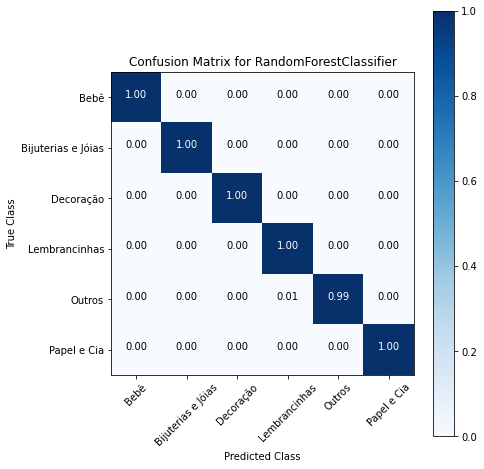

In [37]:
plt.figure(figsize=(7,7))
print("Training Data")
plot_confusion_matrix(best_model, X_train, y_train, normalize=True)

Testing Data


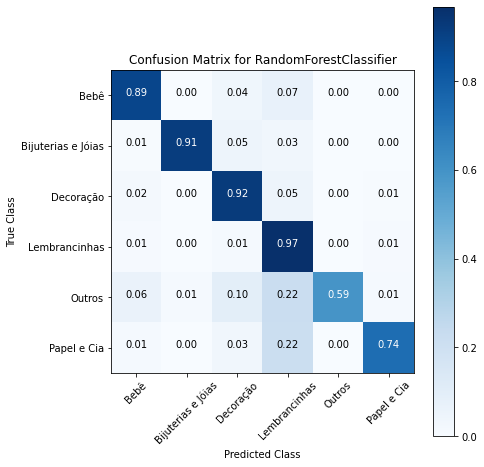

In [38]:
plt.figure(figsize=(7,7))
print("Testing Data")
plot_confusion_matrix(best_model, X_test, y_test, normalize=True)

In addition to the metrics and the confusion matrix, we think it is important to have an idea of the distribution of the categories when using the model. The table below shows the percentage of each true class in the predicted ones.

In [39]:
y_pred = best_model.predict(X_test)
df = pd.DataFrame({"True": y_test, "Predicted": y_pred})
print("Proportion of true classes in the predicted ones")
df.groupby(["Predicted"])['True'].value_counts(normalize=True).round(2)

Proportion of true classes in the predicted ones


Predicted           True              
Bebê                Bebê                  0.94
                    Decoração             0.03
                    Lembrancinhas         0.02
                    Outros                0.01
                    Papel e Cia           0.01
                    Bijuterias e Jóias    0.00
Bijuterias e Jóias  Bijuterias e Jóias    0.96
                    Outros                0.02
                    Decoração             0.01
                    Lembrancinhas         0.01
Decoração           Decoração             0.92
                    Bebê                  0.03
                    Lembrancinhas         0.02
                    Outros                0.01
                    Papel e Cia           0.01
                    Bijuterias e Jóias    0.01
Lembrancinhas       Lembrancinhas         0.90
                    Papel e Cia           0.03
                    Bebê                  0.03
                    Decoração             0.02
                    O

In [40]:
%%time
best_model.predict(X_test.head(1))

CPU times: user 38.4 ms, sys: 4.06 ms, total: 42.5 ms
Wall time: 56.6 ms


array(['Lembrancinhas'], dtype=object)

In [ ]:
%%time
best_model.predict(X_test)

## Model Exportation <a class="anchor" id="model-exportation"></a>

In [ ]:
best_model.fit(X, y); 

In [ ]:
save_model(best_model, os.getenv("MODEL_PATH"))